Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Num PCs: 661
Train distribution: {0: 0.6736276579944854, 1: 0.32637234200551457}
Test distribution : {0: 0.893194669619202, 1: 0.10680533038079798}

--- Entrenando Regresión Logística ---


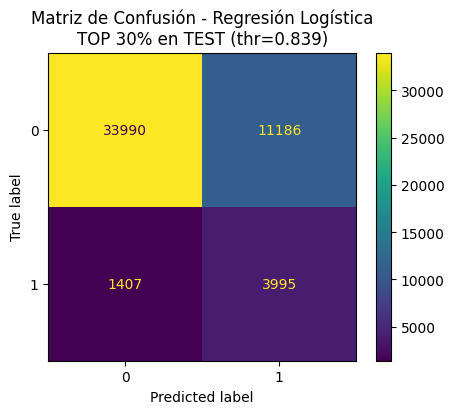


--- Entrenando SVM (LinearSVC Calibrado) ---


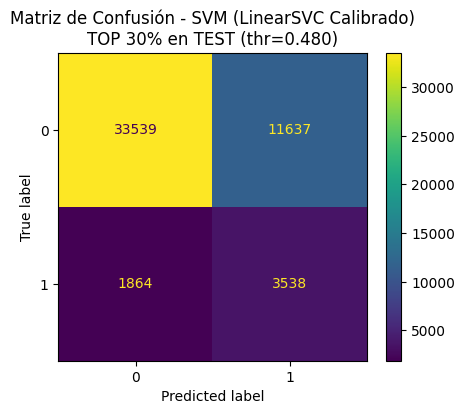


--- Entrenando KNN ---


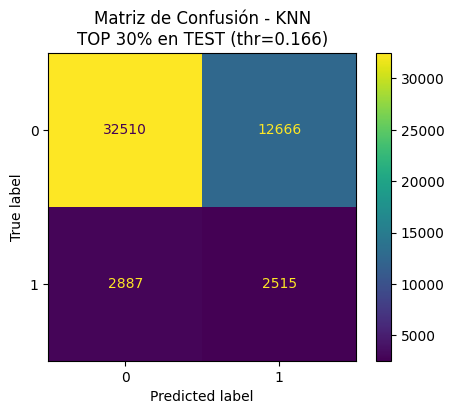


--- Entrenando Random Forest ---


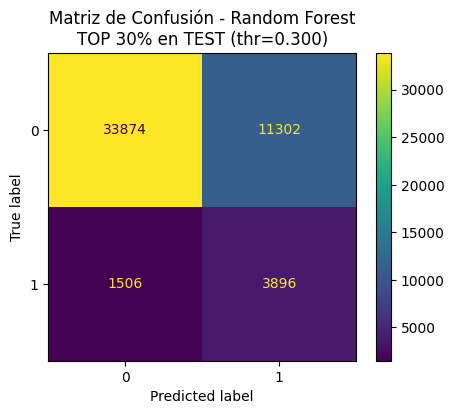


--- Entrenando XGBoost (xgb.train con early stopping) ---


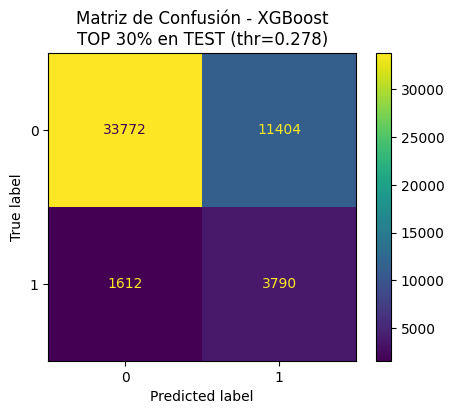


===== Ranking (por PR-AUC) =====


,Modelo,Umbral,Umbral_criterio,Accuracy,Precision,Recall,F1-Score,AUC-ROC,PR-AUC
0,Regresión Logística,0.839229,TOP 30% en TEST (thr=0.839),0.751018,0.263158,0.739541,0.388184,0.804262,0.359552
1,Random Forest,0.299750,TOP 30% en TEST (thr=0.300),0.746767,0.256350,0.721214,0.378252,0.786817,0.310896
2,SVM (LinearSVC Calibrado),0.480213,TOP 30% en TEST (thr=0.480),0.733066,0.233147,0.654943,0.343879,0.753066,0.270948
3,XGBoost,0.278378,TOP 30% en TEST (thr=0.278),0.742655,0.249441,0.701592,0.368033,0.784741,0.261583
4,KNN,0.165841,TOP 30% en TEST (thr=0.166),0.692495,0.165668,0.465568,0.244376,0.610475,0.166415



✅ Mejor modelo por PR-AUC: Regresión Logística (PR-AUC=0.3596)
💾 Bundle (PKL) guardado en: /content/drive/MyDrive/Colab Notebooks/AI Project/best_model_bundle.pkl
🧾 Metadata (JSON) guardado en: /content/drive/MyDrive/Colab Notebooks/AI Project/best_model_bundle.json


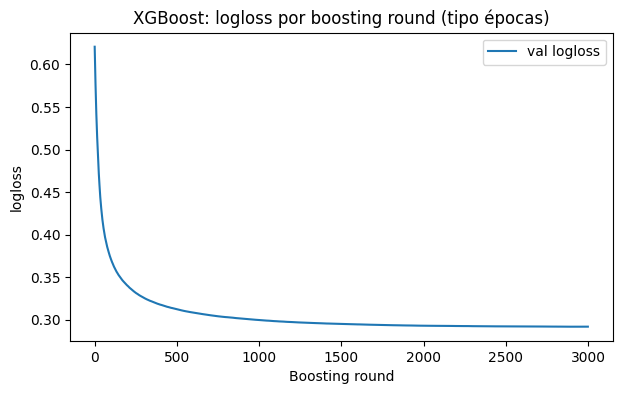

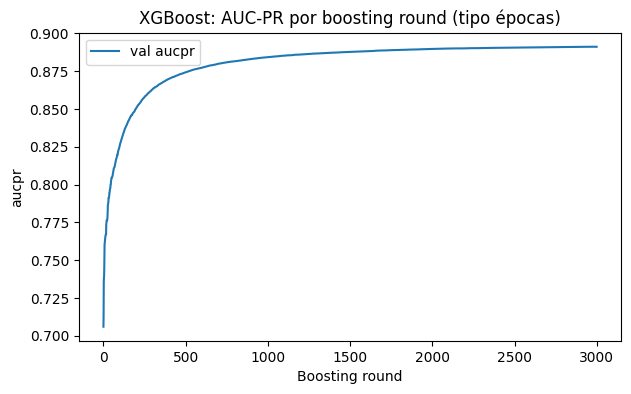

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# =========================
# CONFIGURACIÓN
# =========================
RISK_RATE = 0.30
SAMPLE_SIZE = 30000

# =========================
# Carga de datos
# =========================
from google.colab import drive
drive.mount('/content/drive')

ruta = "/content/drive/MyDrive/Colab Notebooks/AI Project/"

train_df = pd.read_csv(ruta + "train_18_24_pca95_target30_NO_SMOTE.csv")
test_df  = pd.read_csv(ruta + "test_25_pca95_target30_NO_SMOTE.csv")

pc_cols = [c for c in train_df.columns if c.startswith("PC")]
print("Num PCs:", len(pc_cols))

X_train_full = train_df[pc_cols].astype(np.float32)
y_train_full = train_df["Target"].astype(int)

X_test = test_df[pc_cols].astype(np.float32)
y_test = test_df["Target"].astype(int)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print("Train distribution:", y_train_full.value_counts(normalize=True).to_dict())
print("Test distribution :", y_test.value_counts(normalize=True).to_dict())

# Sample para SVM y KNN
if len(X_train_full) > SAMPLE_SIZE:
    idx = np.random.RandomState(42).choice(len(X_train_full), SAMPLE_SIZE, replace=False)
    X_train_sample = X_train_full.iloc[idx]
    y_train_sample = y_train_full.iloc[idx]
else:
    X_train_sample = X_train_full
    y_train_sample = y_train_full

# =========================
# Modelos sklearn (sin XGBoost aquí)
# =========================
modelos = {
    "Regresión Logística": LogisticRegression(
        solver="lbfgs", max_iter=3000, class_weight="balanced"
    ),

    "SVM (LinearSVC Calibrado)": CalibratedClassifierCV(
        estimator=LinearSVC(
            C=0.5,
            class_weight="balanced",
            max_iter=10000,
            tol=1e-3,
            dual=False,
            random_state=42
        ),
        method="sigmoid",
        cv=3
    ),

    "KNN": KNeighborsClassifier(
        n_neighbors=15, weights="distance", n_jobs=-1
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=18,
        min_samples_leaf=5,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42,
        class_weight="balanced_subsample"
    ),
}

# =========================
# Funciones
# =========================
def get_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        s = (s - s.min()) / (s.max() - s.min() + 1e-9)
        return s
    raise ValueError("El modelo no soporta predict_proba ni decision_function.")

def threshold_topk(scores, risk_rate=0.30):
    return float(np.quantile(scores, 1 - risk_rate))

def evaluar_y_plot(nombre, y_score, y_true, risk_rate):
    thr = threshold_topk(y_score, risk_rate=risk_rate)
    y_pred = (y_score >= thr).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_score)
    pr_auc = average_precision_score(y_true, y_score)

    thr_info = f"TOP {int(risk_rate*100)}% en TEST (thr={thr:.3f})"

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, values_format="d")
    ax.set_title(f"Matriz de Confusión - {nombre}\n{thr_info}")
    plt.show()

    row = {
        "Modelo": nombre,
        "Umbral": thr,
        "Umbral_criterio": thr_info,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC-ROC": auc,
        "PR-AUC": pr_auc
    }
    return row

# =========================
# Entrenamiento + selección mejor modelo (PR-AUC)
# =========================
resultados = []
best_pr_auc = -1.0
best_name = None
best_obj = None
best_bundle = None
best_metrics = None
xgb_evals_result = None
xgb_model_path = None

# ---- sklearn models ----
for nombre, modelo in modelos.items():
    print(f"\n--- Entrenando {nombre} ---")

    if nombre in ["SVM (LinearSVC Calibrado)", "KNN"]:
        modelo.fit(X_train_sample, y_train_sample)
    else:
        modelo.fit(X_train_full, y_train_full)

    y_test_score = get_scores(modelo, X_test)
    row = evaluar_y_plot(nombre, y_test_score, y_test, RISK_RATE)
    resultados.append(row)

    if row["PR-AUC"] > best_pr_auc:
        best_pr_auc = row["PR-AUC"]
        best_name = nombre
        best_obj = modelo
        best_metrics = row.copy()
        best_bundle = {
            "model_type": "sklearn",
            "model_name": nombre,
            "model": modelo,
            "threshold": row["Umbral"],
            "pc_cols": pc_cols,
            "risk_rate": RISK_RATE
        }

# ---- XGBoost con xgb.train() (con early stopping compatible) ----
print("\n--- Entrenando XGBoost (xgb.train con early stopping) ---")

dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "learning_rate": 0.05,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 5,
    "lambda": 2.0,
    "alpha": 0.1,
    "tree_method": "hist",
    "seed": 42
}

xgb_evals_result = {}
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1500,
    evals=[(dval, "val")],
    early_stopping_rounds=50,
    evals_result=xgb_evals_result,
    verbose_eval=False
)

y_test_score_xgb = bst.predict(dtest)
row_xgb = evaluar_y_plot("XGBoost", y_test_score_xgb, y_test, RISK_RATE)
resultados.append(row_xgb)

# Selección por PR-AUC (incluyendo XGBoost)
if row_xgb["PR-AUC"] > best_pr_auc:
    best_pr_auc = row_xgb["PR-AUC"]
    best_name = "XGBoost"
    best_obj = bst
    best_metrics = row_xgb.copy()

    # Guarda el modelo real de XGBoost como JSON (modelo, no metadata)
    xgb_model_path = ruta + "best_xgboost_model.json"
    bst.save_model(xgb_model_path)

    best_bundle = {
        "model_type": "xgboost_booster",
        "model_name": "XGBoost",
        "threshold": row_xgb["Umbral"],
        "pc_cols": pc_cols,
        "risk_rate": RISK_RATE,
        "xgb_model_path": xgb_model_path
    }

# Ranking final por PR-AUC
res_df = pd.DataFrame(resultados).sort_values("PR-AUC", ascending=False).reset_index(drop=True)
print("\n===== Ranking (por PR-AUC) =====")
display(res_df)

print(f"\n✅ Mejor modelo por PR-AUC: {best_name} (PR-AUC={best_pr_auc:.4f})")

# =========================
# Guardar mejor bundle (.pkl) + metadata (.json)
# =========================
pkl_path = ruta + "best_model_bundle.pkl"
joblib.dump(best_bundle, pkl_path)
print(f"💾 Bundle (PKL) guardado en: {pkl_path}")

json_payload = {
    "model_name": best_name,
    "model_type": best_bundle.get("model_type"),
    "threshold": float(best_bundle["threshold"]),
    "risk_rate": float(best_bundle["risk_rate"]),
    "pc_cols": list(best_bundle["pc_cols"]),
    "best_metrics": {k: (float(v) if isinstance(v, (np.floating, float, int)) else v)
                     for k, v in best_metrics.items() if k != "Modelo"},
    "xgb_model_path": best_bundle.get("xgb_model_path", None)
}

json_path = ruta + "best_model_bundle.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(json_payload, f, ensure_ascii=False, indent=2)
print(f"🧾 Metadata (JSON) guardado en: {json_path}")

# =========================
# Curva tipo "épocas" (XGBoost) -> logloss y aucpr en validación
# =========================
if xgb_evals_result is not None:
    if "val" in xgb_evals_result:
        if "logloss" in xgb_evals_result["val"]:
            plt.figure(figsize=(7,4))
            plt.plot(xgb_evals_result["val"]["logloss"], label="val logloss")
            plt.title("XGBoost: logloss por boosting round (tipo épocas)")
            plt.xlabel("Boosting round")
            plt.ylabel("logloss")
            plt.legend()
            plt.show()

        if "aucpr" in xgb_evals_result["val"]:
            plt.figure(figsize=(7,4))
            plt.plot(xgb_evals_result["val"]["aucpr"], label="val aucpr")
            plt.title("XGBoost: AUC-PR por boosting round (tipo épocas)")
            plt.xlabel("Boosting round")
            plt.ylabel("aucpr")
            plt.legend()
            plt.show()


In [6]:
import geopandas as gpd

# --- paths (ajusta si lo mueves a repo) ---
PATH_CANT_SHP = "/content/drive/MyDrive/Colab Notebooks/AI Project/GeoJSON Ecuador/Cantones/SHP/nxcantones.shp"
PATH_PROV_SHP = "/content/drive/MyDrive/Colab Notebooks/AI Project/GeoJSON Ecuador/Provincias/LIMITE_PROVINCIAL_CONALI_CNE_2022.shp"

OUT_CANT_GEOJSON = "/content/drive/MyDrive/Colab Notebooks/AI Project/assets/geo/cantones.geojson"
OUT_PROV_GEOJSON = "/content/drive/MyDrive/Colab Notebooks/AI Project/assets/geo/provincias.geojson"

# --- Cantones ---
cant = gpd.read_file(PATH_CANT_SHP)

# a web-friendly CRS
cant = cant.to_crs("EPSG:4326")

# normaliza tipos/códigos (strings con ceros a la izquierda)
cant["DPA_CANTON"] = cant["DPA_CANTON"].astype(str).str.zfill(4)
cant["DPA_PROVIN"] = cant["DPA_PROVIN"].astype(str).str.zfill(2)

# deja solo lo necesario (reduce peso)
cant = cant[["DPA_CANTON", "DPA_DESCAN", "DPA_PROVIN", "DPA_DESPRO", "geometry"]]

# Simplificar geometría para que pese menos
cant["geometry"] = cant["geometry"].simplify(tolerance=0.001, preserve_topology=True)

cant.to_file(OUT_CANT_GEOJSON, driver="GeoJSON")

# --- Provincias ---
prov = gpd.read_file(PATH_PROV_SHP).to_crs("EPSG:4326")

# asegúrate de tener CODPRO
prov["CODPRO"] = prov["CODPRO"].astype(str).str.zfill(2)

# (opcional) conserva también nombre si existe (cambia NOMPRO/DPA_DESPRO según tu shapefile)
cols = ["CODPRO"]
for candidate in ["NOMPRO", "DPA_DESPRO", "PROVINCIA", "NOMBRE"]:
    if candidate in prov.columns:
        cols.append(candidate)
        break

prov = prov[cols + ["geometry"]]

#Simplificar
prov["geometry"] = prov["geometry"].simplify(tolerance=0.001, preserve_topology=True)

prov.to_file(OUT_PROV_GEOJSON, driver="GeoJSON")

print("Listo:", OUT_CANT_GEOJSON, OUT_PROV_GEOJSON)

Listo: /content/drive/MyDrive/Colab Notebooks/AI Project/assets/geo/cantones.geojson /content/drive/MyDrive/Colab Notebooks/AI Project/assets/geo/provincias.geojson


In [26]:
import joblib
import pandas as pd
import numpy as np
import json
from pathlib import Path


ART_DIR = "/content/drive/MyDrive/Colab Notebooks/AI Project/artifacts"

PREP_PKL  = f"{ART_DIR}/preprocess_bundle.pkl"
MODEL_PKL = f"{ART_DIR}/best_model_bundle.pkl"

PROV_GEOJSON = "/content/drive/MyDrive/Colab Notebooks/AI Project/assets/geo/provincias.geojson"
CANT_GEOJSON = "/content/drive/MyDrive/Colab Notebooks/AI Project/assets/geo/cantones.geojson"

OUT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/AI Project/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

prep = joblib.load(PREP_PKL)
mb   = joblib.load(MODEL_PKL)

model = mb["model"]
thr   = float(mb["threshold"])

print("OK preprocess keys:", prep.keys())
print("OK model keys:", mb.keys())
print("Threshold:", thr)
print("PCA k:", len(prep["pc_cols"]))

def preprocesar_features(df):
    df = df.copy()

    cols_a_eliminar = []
    fugas_data = [
        "codigo", "amie", "fex_", "puntuacion", "inev", "imat", "ilyl", "icn", "ies",
        "ihis", "ifil", "ied", "ifis", "iqui", "ibio", "nl_"
    ]

    for col in df.columns:
        if col == "Target":
            continue
        if any(key in col.lower() for key in fugas_data):
            cols_a_eliminar.append(col)
        elif df[col].dtype == "object" and df[col].nunique(dropna=True) > 100 and "id_" not in col.lower():
            cols_a_eliminar.append(col)

    df = df.drop(columns=list(set(cols_a_eliminar)), errors="ignore")

    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].astype("category")
    for col in ["id_prov", "id_cant", "grado"]:
        if col in df.columns:
            df[col] = df[col].astype("category")

    df = pd.get_dummies(df, drop_first=True)
    df = df.fillna(0)
    return df.astype("float32")

def read_csv_smart(path):
    # prueba separadores + encodings comunes
    seps = [";", ",", "\t", "|"]
    encs = ["utf-8", "latin1", "cp1252"]
    last_err = None

    for enc in encs:
        for sep in seps:
            try:
                df = pd.read_csv(path, sep=sep, encoding=enc, low_memory=False, engine="python")
                if df.shape[1] > 1:
                    return df, sep, enc
            except Exception as e:
                last_err = e

    df = pd.read_csv(path, sep=None, engine="python", encoding="latin1", on_bad_lines="skip")
    return df, None, "latin1"

def predict_and_export_heat(input_csv: str, out_prefix="sest"):
    # 1) cargar crudo
    df_raw, sep_used, enc_used = read_csv_smart(input_csv)
    print(f"CSV leído con sep={sep_used} encoding={enc_used} shape={df_raw.shape}")

    # 2) separar IDs (para agrupar)
    # En tu SEST suelen existir id_prov e id_cant
    id_prov = df_raw["id_prov"].astype(str).str.zfill(2) if "id_prov" in df_raw.columns else None
    id_cant = df_raw["id_cant"].astype(str).str.zfill(4) if "id_cant" in df_raw.columns else None

    # 3) preprocesar (dummies + limpieza)
    X = preprocesar_features(df_raw)

    # 4) alinear columnas exactamente como en training (1072)
    X = X.reindex(columns=prep["model_input_cols"], fill_value=0)

    # 5) scaler + pca
    X_scaled = prep["scaler"].transform(X)
    X_pca = prep["pca"].transform(X_scaled)
    X_pca = pd.DataFrame(X_pca, columns=prep["pc_cols"])

    # 6) predicción
    proba = model.predict_proba(X_pca[mb["pc_cols"]])[:, 1]

    df_out = df_raw.copy()
    df_out["risk_score"] = proba
    df_out["risk_flag"]  = (df_out["risk_score"] >= thr).astype(int)

    # 7) asegurar ids (para mapa)
    if id_prov is not None:
        df_out["CODPRO"] = id_prov
    if id_cant is not None:
        df_out["DPA_CANTON"] = id_cant

    # --- outputs ---
    pred_path = OUT_DIR / f"{out_prefix}_predicciones.csv"
    df_out.to_csv(pred_path, index=False)

    # 8) agregación provincias
    if "CODPRO" in df_out.columns:
        prov = (df_out.groupby("CODPRO")
                .agg(n=("risk_score","size"),
                     mean_risk=("risk_score","mean"),
                     pct_flag=("risk_flag","mean"))
                .reset_index())
        prov["pct_flag"] = (prov["pct_flag"]*100).round(2)
        prov["mean_risk"] = prov["mean_risk"].round(6)
        prov_path = OUT_DIR / f"{out_prefix}_heat_provincias.json"
        prov.to_json(prov_path, orient="records", force_ascii=False)
    else:
        prov_path = None

    # 9) agregación cantones
    if "DPA_CANTON" in df_out.columns:
        cant = (df_out.groupby(["CODPRO","DPA_CANTON"])
                .agg(n=("risk_score","size"),
                     mean_risk=("risk_score","mean"),
                     pct_flag=("risk_flag","mean"))
                .reset_index())
        cant["pct_flag"] = (cant["pct_flag"]*100).round(2)
        cant["mean_risk"] = cant["mean_risk"].round(6)
        cant_path = OUT_DIR / f"{out_prefix}_heat_cantones.json"
        cant.to_json(cant_path, orient="records", force_ascii=False)
    else:
        cant_path = None

    meta = {"threshold": thr, "rows": int(len(df_out))}
    meta_path = OUT_DIR / f"{out_prefix}_meta.json"
    meta_path.write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")

    print("✅ Listo outputs:")
    print("-", pred_path)
    if prov_path: print("-", prov_path)
    if cant_path: print("-", cant_path)
    print("-", meta_path)

    return df_out

df_pred = predict_and_export_heat(input_csv="/content/drive/MyDrive/Colab Notebooks/AI Project/SEST25_micro_50578_20251215_CSV.csv", out_prefix="SEST25")



OK preprocess keys: dict_keys(['model_input_cols', 'scaler', 'pca', 'pc_cols', 'id_cols', 'target_rate', 'low_prop_threshold_t', 'exclude_nl_inev', 'created_at'])
OK model keys: dict_keys(['model_type', 'model_name', 'model', 'threshold', 'pc_cols', 'risk_rate'])
Threshold: 0.8392292919095269
PCA k: 661
CSV leído con sep=None encoding=latin1 shape=(50578, 76)
✅ Listo outputs:
- /content/drive/MyDrive/Colab Notebooks/AI Project/outputs/SEST25_predicciones.csv
- /content/drive/MyDrive/Colab Notebooks/AI Project/outputs/SEST25_heat_provincias.json
- /content/drive/MyDrive/Colab Notebooks/AI Project/outputs/SEST25_heat_cantones.json
- /content/drive/MyDrive/Colab Notebooks/AI Project/outputs/SEST25_meta.json


In [ ]:
!pip -q install folium geopandas

import geopandas as gpd
import pandas as pd
import folium
from folium.features import GeoJsonTooltip
from pathlib import Path

# =========================
# RUTAS (ajusta BASE si hace falta)
# =========================
BASE = "/content/drive/MyDrive/Colab Notebooks/AI Project"

PROV_GEOJSON = f"{BASE}/assets/geo/provincias.geojson"
CANT_GEOJSON = f"{BASE}/assets/geo/cantones.geojson"

HEAT_PROV = f"{BASE}/outputs/SEST25_heat_provincias.json"
HEAT_CANT = f"{BASE}/outputs/SEST25_heat_cantones.json"

OUT_DIR = Path(f"{BASE}/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# CARGA
# =========================
gprov = gpd.read_file(PROV_GEOJSON)
gcant = gpd.read_file(CANT_GEOJSON)

prov_heat = pd.read_json(HEAT_PROV)
cant_heat = pd.read_json(HEAT_CANT)

# Normalizar llaves
gprov["CODPRO"] = gprov["CODPRO"].astype(str).str.zfill(2)
prov_heat["CODPRO"] = prov_heat["CODPRO"].astype(str).str.zfill(2)

gcant["DPA_CANTON"] = gcant["DPA_CANTON"].astype(str).str.zfill(4)
cant_heat["DPA_CANTON"] = cant_heat["DPA_CANTON"].astype(str).str.zfill(4)

# Merge (NO rellenamos NaN -> así se ve "sin datos" en blanco)
gprov_m = gprov.merge(prov_heat, on="CODPRO", how="left")
gcant_m = gcant.merge(cant_heat, on="DPA_CANTON", how="left")

# =========================
# Helper: escoger columnas de nombre si existen
# =========================
def pick_name_col(gdf, candidates):
    for c in candidates:
        if c in gdf.columns:
            return c
    return None

prov_name = pick_name_col(gprov_m, ["NOMPRO", "DPA_DESPRO", "PROVINCIA", "NOMBRE"])
cant_name = pick_name_col(gcant_m, ["DPA_DESCAN", "CANTON", "NOMBRE"])

# =========================
# Construir mapa choropleth (paleta YlOrRd)
# =========================
def make_choropleth(gdf, key_col, metric, title, out_html, center=(-1.5, -78.4), zoom=6):
    m = folium.Map(location=list(center), zoom_start=zoom, tiles="cartodbpositron")

    # Choropleth: paleta amarillo->naranja->rojo
    folium.Choropleth(
        geo_data=gdf.__geo_interface__,
        data=gdf[[key_col, metric]],
        columns=[key_col, metric],
        key_on=f"feature.properties.{key_col}",
        fill_color="YlOrRd",          # <-- tu paleta
        fill_opacity=0.80,
        line_opacity=0.25,
        nan_fill_color="#948F8D",
        nan_fill_opacity=0.4,
        legend_name=title,
    ).add_to(m)

    # Tooltip con campos útiles
    tooltip_fields = [key_col]
    tooltip_aliases = [f"{key_col}:"]

    # agrega nombre si existe
    if key_col == "CODPRO" and prov_name:
        tooltip_fields.insert(0, prov_name)
        tooltip_aliases.insert(0, "Provincia:")
    if key_col == "DPA_CANTON" and cant_name:
        tooltip_fields.insert(0, cant_name)
        tooltip_aliases.insert(0, "Cantón:")

    # métricas
    for f, a in [("mean_risk", "Riesgo promedio:"), ("pct_flag", "% marcados riesgo:"), ("n", "N:")]:
        if f in gdf.columns:
            tooltip_fields.append(f)
            tooltip_aliases.append(a)

    folium.GeoJson(
        gdf,
        name="Datos",
        tooltip=GeoJsonTooltip(fields=tooltip_fields, aliases=tooltip_aliases, localize=True),
        style_function=lambda x: {"weight": 0.6, "color": "#666", "fillOpacity": 0.0},
        highlight_function=lambda x: {"weight": 2.0, "color": "#111"},
    ).add_to(m)

    folium.LayerControl().add_to(m)
    m.save(out_html)
    print("✅ Guardado:", out_html)
    return m

# =========================
# Generar mapas (PROVINCIAS)
# =========================
m_prov_pct = make_choropleth(
    gdf=gprov_m,
    key_col="CODPRO",
    metric="pct_flag",
    title="Provincias - % marcados como riesgo (amarillo=bajo, rojo=alto)",
    out_html=str(OUT_DIR / "mapa_provincias_pctflag_YlOrRd.html"),
    zoom=6
)

m_prov_mean = make_choropleth(
    gdf=gprov_m,
    key_col="CODPRO",
    metric="mean_risk",
    title="Provincias - Riesgo promedio (amarillo=bajo, rojo=alto)",
    out_html=str(OUT_DIR / "mapa_provincias_meanrisk_YlOrRd.html"),
    zoom=6
)

# =========================
# Generar mapas (CANTONES) - puede ser más pesado
# =========================
m_cant_pct = make_choropleth(
    gdf=gcant_m,
    key_col="DPA_CANTON",
    metric="pct_flag",
    title="Cantones - % marcados como riesgo (amarillo=bajo, rojo=alto)",
    out_html=str(OUT_DIR / "mapa_cantones_pctflag_YlOrRd.html"),
    zoom=6
)

m_cant_mean = make_choropleth(
    gdf=gcant_m,
    key_col="DPA_CANTON",
    metric="mean_risk",
    title="Cantones - Riesgo promedio (amarillo=bajo, rojo=alto)",
    out_html=str(OUT_DIR / "mapa_cantones_meanrisk_YlOrRd.html"),
    zoom=6
)

# Mostrar uno (Colab muestra el último objeto)
m_prov_pct
